Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [307]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt
from scipy import stats
from scipy.interpolate import interp1d

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [308]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [309]:
data = load_csv_data('csv_test_data')
print(data.keys())

try:
    acc = data['Linear_Acceleration']
    gyr = data['Gyroscope']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope', 'Linear_Acceleration'])


Funktion zum Plotten

In [310]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], mode='lines+markers', marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Plotten Springen

Plotten Kniebeuge

In [311]:
compare_acc_gyr(acc,gyr)

### Relevante Spalten extrahieren

In [312]:
print(acc.head())

   Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.024174                      -0.297667                       3.237493   
1  0.034154                      -0.566137                       5.267785   
2  0.044163                      -1.054311                       7.098951   
3  0.054143                      -1.432381                       8.608967   
4  0.064152                      -1.469628                       9.717705   

   Linear Acceleration z (m/s^2)  
0                       0.144290  
1                       0.156283  
2                       0.125469  
3                       0.590331  
4                       1.138354  


In [313]:
linear_acc_x = acc['Linear Acceleration x (m/s^2)']
linear_acc_y = acc['Linear Acceleration y (m/s^2)']

gyroskop_x = gyr['Gyroscope x (rad/s)']

time = acc['Time (s)']

combined_df = pd.DataFrame({
    'Gyroscope x (rad/s)': gyroskop_x,
    'Linear Acceleration x (m/s^2)': linear_acc_x,
    'Linear Acceleration y (m/s^2)': linear_acc_y,
    'Time (s)': time
})



In [314]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])

    num_columns = len(filtered_df.columns)
    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        positive_indices = np.where(frequencies > 0)
        
        positive_frequencies = frequencies[positive_indices]
        positive_amplitudes = amplitudes[positive_indices]

        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

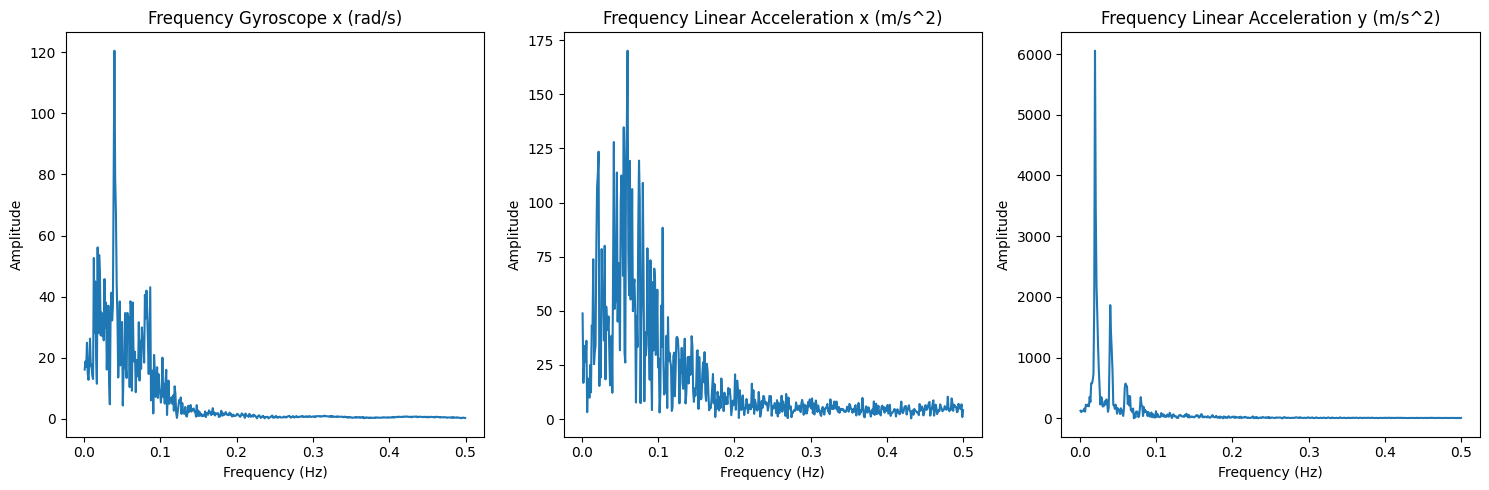

In [315]:
plot_frequencies(combined_df)

### Filtern der Frequenzen

In den Plots ist erkennbar, dass der Großteil der Daten sich im Bereich bis 0,3 Hz befindet. Dies deutet darauf hin, dass 
die wesentlichen Bewegungsinformationen für Aktivitäten wie Kniebeugen und Sprünge in diesem niedrigen Frequenzbereich liegen.
Bei Kniebeugen und Sprüngen handelt es sich um relativ langsame Bewegungen, die durch größere, kontrollierte Muskelbewegungen
gekennzeichnet sind, im Gegensatz zu schnellen, feinen Bewegungen. Die niedrigeren Frequenzen repräsentieren diese langsameren,
großformatigen Bewegungen besser, während höhere Frequenzen tendenziell schnelle, kleine oder zufällige Bewegungen darstellen,
die möglicherweise als Rauschen betrachtet werden können.

In [316]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 4 
    high_cutoff = 0.3

    # Butterworth Hochpassfilter erstellen
    b, a = butter(filter_order, high_cutoff, btype='high', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe